In [1]:
import numpy as np
import fitsio
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
import os
import tqdm
import scipy.optimize
import healpy as hp
# sys.path.append('/home/zhuoqizhang/miniconda3/envs/shearDM/lib/python3.10/site-packages/')
import pymaster as nmt
import os
nside = 1024
npix = hp.nside2npix(nside)

In [3]:
abspath = False

catpath = 'metacal_gold_combined_20230613.hdf'
fgpath = 'Gold_Foreground_20230607.fits'
    
if abspath: 
    catpath = '/project2/chihway/data/decade/metacal_gold_combined_20230613.hdf'
    fgpath = '/project/chihway/dhayaa/DECADE/Gold_Foreground_20230607.fits'

In [4]:
def rotate_ellipticities(e1, e2, rot_angle):
        """
        Random rotate ellipticities e1 and e2 over
        angles given in `rot_angle`, which is in
        units of radians
        """

        #Rotate galaxy shapes randomly
        cos = np.cos(rot_angle)
        sin = np.sin(rot_angle)

        e1_rand = + e1 * cos + e2 * sin
        e2_rand = - e1 * sin + e2 * cos

        return e1_rand, e2_rand

In [5]:
with h5py.File(catpath, 'r') as f:

    ra      = np.array(f['RA'])
    dec     = np.array(f['DEC'])
    e1, e2  = np.array(f['mcal_g_noshear']).T
    weight  = np.array(f['mcal_g_w'])

    mag_r   = 30 - 2.5*np.log10(np.array(f['mcal_flux_noshear'])[:, 0])
    mag_i   = 30 - 2.5*np.log10(np.array(f['mcal_flux_noshear'])[:, 1])
    mag_z   = 30 - 2.5*np.log10(np.array(f['mcal_flux_noshear'])[:, 2])

    SNR     = np.array(f['mcal_s2n_noshear'])
    T_ratio = np.array(f['mcal_T_ratio_noshear'])
    T       = np.array(f['mcal_T_noshear'])
    flags   = np.array(f['mcal_flags'])

    GOLD_Foreground  = hp.read_map(fgpath, dtype = int)
    FLAGS_Foreground = GOLD_Foreground[hp.ang2pix(hp.npix2nside(GOLD_Foreground.size), ra, dec, lonlat = True)]

    #Metacal cuts based on DES Y3 ones (from here: https://des.ncsa.illinois.edu/releases/y3a2/Y3key-catalogs)

    SNR_Mask   = (SNR > 10) & (SNR < 1000)
    Tratio_Mask= T_ratio > 0.5
    T_Mask     = T < 10
    Flag_Mask  = flags == 0
    Other_Mask = np.invert((T > 2) & (SNR < 30)) & np.invert((np.log10(T) < (22.25 - mag_r)/3.5) & (e1**2 + e2**2 > 0.8**2))
    GOLD_Mask  = FLAGS_Foreground == 0 #From gold catalog
    SG_Mask    = np.array(f['sg_bdf']) >= 4 #Star-galaxy separator
    Color_Mask = ((18 < mag_i) & (mag_i < 23.5) & 
                  (15 < mag_r) & (mag_r < 26) & 
                  (15 < mag_z) & (mag_z < 26) & 
                  (-1.5 < mag_r - mag_i) & (mag_r - mag_i < 4) & 
                  (-1.5 < mag_i - mag_z) & (mag_i - mag_z < 4)
                 )

    print(np.sum(SNR_Mask), np.sum(Tratio_Mask), np.sum(T_Mask), np.sum(Flag_Mask), np.sum(Other_Mask))

    Mask = SNR_Mask & Tratio_Mask & T_Mask & Flag_Mask & Color_Mask & Other_Mask & GOLD_Mask & SG_Mask
    print("TOTAL NUM", np.sum(Mask))

    e1  = e1[Mask]
    e2  = -e2[Mask]
    ra  = ra[Mask]
    dec = dec[Mask]
    #weight   = np.ones_like(weight[Mask])
    weight = weight[Mask]

/tmp/ipykernel_298935/4114472705.py:8: RuntimeWarning: invalid value encountered in log10
  mag_r   = 30 - 2.5*np.log10(np.array(f['mcal_flux_noshear'])[:, 0])
/tmp/ipykernel_298935/4114472705.py:9: RuntimeWarning: invalid value encountered in log10
  mag_i   = 30 - 2.5*np.log10(np.array(f['mcal_flux_noshear'])[:, 1])
/tmp/ipykernel_298935/4114472705.py:10: RuntimeWarning: invalid value encountered in log10
  mag_z   = 30 - 2.5*np.log10(np.array(f['mcal_flux_noshear'])[:, 2])
/tmp/ipykernel_298935/4114472705.py:26: RuntimeWarning: invalid value encountered in log10
  Other_Mask = np.invert((T > 2) & (SNR < 30)) & np.invert((np.log10(T) < (22.25 - mag_r)/3.5) & (e1**2 + e2**2 > 0.8**2))


133507096 109339922 242858406 244200019 240073201
TOTAL NUM 45407069


In [6]:
pix = hp.nside2npix(nside)
map_counts = np.zeros(npix)
map_e1 = np.zeros(npix)
map_e2 = np.zeros(npix)
pix = hp.ang2pix(nside, ra, dec, lonlat=True)
ind, counts = np.unique(pix, return_counts=True)
map_weight = np.bincount(pix, weight, minlength=npix)
# Note that we set response to 1. This shouldn't change the relative amplitude of C_ell
map_e1 += np.bincount(pix,e1*weight,minlength=npix)/map_weight
map_e2 += np.bincount(pix,e2*weight,minlength=npix)/map_weight
map_e1[np.isnan(map_e1)] = 0
map_e2[np.isnan(map_e2)] = 0
mask = map_weight>0
#mask = map_weight


edge = (np.linspace(np.sqrt(8), np.sqrt(2048), 33)**2).astype(np.int_)
b = nmt.NmtBin.from_edges(edge[:-1],edge[1:])
ell_eff = b.get_effective_ells()
f2 = nmt.NmtField(mask, [map_e1, map_e2])

/tmp/ipykernel_298935/2127273188.py:9: RuntimeWarning: invalid value encountered in true_divide
  map_e1 += np.bincount(pix,e1*weight,minlength=npix)/map_weight
/tmp/ipykernel_298935/2127273188.py:10: RuntimeWarning: invalid value encountered in true_divide
  map_e2 += np.bincount(pix,e2*weight,minlength=npix)/map_weight


In [18]:
w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f2, f2, b)
cl_coupled = nmt.compute_coupled_cell(f2, f2)
cl_decoupled = w.decouple_cell(cl_coupled)

100%|██████████| 50/50 [35:45<00:00, 42.91s/it]


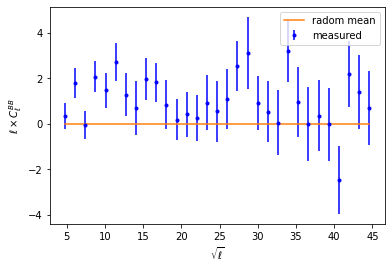

In [19]:
#np.save(f'/project2/chihway/jackie/decade/Bmode-DES/Cl_{fname[17:]}', cl_decoupled)

N=50
footprint = mask!=0
BB_rand = []

for j in tqdm.trange(N): 

    # generate random_samples
    pix = hp.ang2pix(nside, ra, dec, lonlat=True)
    rot_angle = np.random.default_rng(j).random(e1.size)*2*np.pi
    e1_rot, e2_rot = rotate_ellipticities(e1, e2, rot_angle)

    rand_e1 = np.zeros(npix)
    rand_e2 = np.zeros(npix)
    rand_e1[footprint] = np.bincount(pix,e1_rot*weight,minlength=npix)[footprint]/map_weight[footprint]
    rand_e2[footprint] = np.bincount(pix,e2_rot*weight,minlength=npix)[footprint]/map_weight[footprint]
    frand = nmt.NmtField(mask, [rand_e1, rand_e2])
    BB_rand.append(w.decouple_cell(nmt.compute_coupled_cell(frand, frand)))

BB_rand = np.array(BB_rand)   
#np.save(f'/project2/chihway/jackie/decade/Bmode-DES/rand_{fname[17:]}', BB_rand)


mean = np.mean(BB_rand[:,3,1:],axis=0)
std = np.std(BB_rand[:,3,1:],axis=0)
plt.errorbar(np.sqrt(ell_eff[1:]), 1e8*ell_eff[1:]*(cl_decoupled[3][1:]-mean), yerr=1e8*ell_eff[1:]*std,label='measured',fmt='.b')
plt.plot(np.sqrt(ell_eff[1:]), 0*mean, color='tab:orange',label='radom mean')
plt.legend()
plt.xlabel(r'$\sqrt{\ell}$')
plt.ylabel(r'$\ell\times C_\ell^{BB}$')
#plt.title(fname[17:-4])
plt.show()

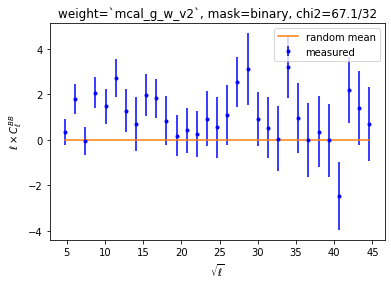

In [20]:
chi2 = np.round(np.sum((cl_decoupled[3][1:]-mean)**2/std**2),1)
mean = np.mean(BB_rand[:,3,1:],axis=0)
std = np.std(BB_rand[:,3,1:],axis=0)
plt.errorbar(np.sqrt(ell_eff[1:]), 1e8*ell_eff[1:]*(cl_decoupled[3][1:]-mean), yerr=1e8*ell_eff[1:]*std,label='measured',fmt='.b')
plt.plot(np.sqrt(ell_eff[1:]), 0*mean, color='tab:orange',label='random mean')
plt.legend()
plt.xlabel(r'$\sqrt{\ell}$')
plt.ylabel(r'$\ell\times C_\ell^{BB}$')
plt.title(f'weight=`mcal_g_w_v2`, mask=binary, chi2={chi2}/32')
plt.show()